Lambda School Data Science

*Unit 4, Sprint 3, Module 1*

---


# 1. Recurrent Neural Networks (RNNs) and Long Short Term Memory (LSTM) -- Prepare



![](https://wiki.tum.de/download/attachments/22578349/GATES.gif?version=1&modificationDate=1486083227237&api=v2)

## Learning Objectives
- <a href="#p1">Part 1: </a>Describe How Neural Networks are used for modeling sequences
- <a href="#p2">Part 2: </a>Apply a LSTM to a text classification problem using Keras

-----
## Overview

### Let's start with sequences 

A sequence is a collection of numbers, taking into account their order; repetition is allowed. 

Python lists are a good elemental example - `[1, 2, 2, -1]` is a valid list and is different from `[1, 2, -1, 2]`. 


## 1.1 Recursion (Learn)



Before we dive into the inner workings of an LSTM model, let's try to understand and appreciate **recursion** in sequences. <br>A **recursive sequence** is a sequence in which the next number can be computed from one or more of the previous numbers via a [**recurrence relation**](https://en.wikipedia.org/wiki/Recurrence_relation). Recursion occurs in both pure mathematics and in the physical world in which we find ourselves embedded. <br><br>
The root word is **recur**, which means "to occur repeatedly". Given a few consecutive values, the rest of a recursive sequence can be generated by repeatedly applying its recursion relation! 


As usual, we attempt to understand a concept from at least 3 different perspectives:
- Algebraic
- Geometric
- Coding an example

A famous example of a recursive sequence in mathematics is the [Fibonacci numbers](https://en.wikipedia.org/wiki/Fibonacci_number). Fibonacci was an Italian mathematician, who wrote about these numbers in **The Book of Calculation**, in 1202 AD. Although the sequence is named after him, it was known long before his time in India.

The Fibonacci numbers are an infinite sequence of integers, beginning with $[0, 1]$ in which the $ith$ number (for $i>1$) is the sum of the two previous numbers.

Here is the algorithm for generating the numbers in the Fibonacci sequence: 

$$F_n = F_{n-1} + F_{n-2}$$

You need a **base case** $F_0=0$ and $F_1=1$ to get the sequence started.

Starting from the base case, the recursion relation generates the entire sequence:

$F_0=0,~~  F_1=1 $<br><br>

$F_2 = F_{1} + F_{0} ~=~ 1 + 0 ~=~ 1$<br><br>

Then

$F_3 = F_{2} + F_{1} ~=~ 1 + 1 ~=~ 2$<br><br>

Then 

$F_4 = F_{3} + F_{2} ~=~ 2 + 2 ~=~ 3$<br><br>

Then 

$F_5 = F_{4} + F_{3} ~=~ 3 + 2 ~=~ 5$<br><br>

etc.

Get the idea?

Try: what are $F_{6}$ and $F_{7}$?



### Before coding up the Fibonacci sequence, let's take a moment to appreciate its beauty, and how important and ubiquitous it is in nature!

#### **Contruction of the ["Golden Spiral"](https://en.wikipedia.org/wiki/Golden_spiral)**
![](http://www.davidbeahm.com/wp-content/uploads/2011/11/fibonacci-1024x637.jpg)

#### **Snail Shells**
![](https://i.pinimg.com/originals/32/d7/47/32d747bea24f4756dc4c5ffe61b36efd.jpg)

#### **The Mona Lisa**
![](https://i.pinimg.com/originals/f2/cb/34/f2cb3452dd774bab87bbee2b8a77d4bb.png)

#### **A Spiral Galaxy**
![](https://f4.bcbits.com/img/a3628582449_10.jpg)



#### **Take Away:** 
- There are often surprising connections between mathematics and physical phenomena
- The world contains many examples of recursive sequences


### Coding the Fibonacci Sequence using a recursive function
*This is a standard problem that comes up in interviews for software engineering jobs!*<br><br>

A recursive function is a function that can call itself!<br>
For a recursive function to be defined, there must be a base case that the function eventually reaches by repeatedly calling itself.

For the Fibonacci sequence, the base case is<br>
$$F_0=0 ~\text{and}~ F_1=1$$
Again, here is the algorithm for the Fibonacci numbers.  


$$F_n = F_{n-1} + F_{n-2}$$<br>

So we want a recursive function that, given an integer $n$ computes the $nth$ Fibonacci number by repeatedly calling itself.


In [ ]:
def fibo(n):
    """
    Calculate and return the next number in the Fibonacci sequence
    
    Input
    -----
    n: int or float
        The nth number in the sequence (think of it as an index for a list)
        
    Return
    ------
    F_n: the next number in the sequence generated from the previous two numbers in the sequence 
    """
    
    if n <= 1: # this is the base case
        return n
    else: # this is the recursive part 
        # notice how the function calls itself!
        #  F_n =       F_n-1 + F_n-2
        return(fibo(n-1) + fibo(n-2))

In [ ]:
# Using our recursive function, generate the first 10 values of the Fibonacci Sequence
###BEGIN SOLUTION
[fibo(n) for n in range(10)]
###END SOLUTION

[0, 1, 1, 2, 3, 5, 8, 13, 21, 34]

In [ ]:
fibo(20)

6765

**Take Away:** 

Recursive algorithms have as input their previous output. <br>
In other words, the output at time step $t - 1$, becomes the input for the following time step $t$.<br><br> 
This key idea of recursion underlies the construction of a Recurrent Neural Network, specifically the LSTM model. 

-----

## 1.2 Introduction to Recursive Neural Networks (RNNs) 


The nice thing about spending time to understand the Fibonacci Sequence is that we can then build on the intuition we gained to help us understand how the LSTM works. 

Recurrent Neural Networks (RNNs) have a recursive loop in their architecture. The RNN model was first formulated in the original [backpropagation paper](https://chsasank.com/classic_papers/learning-representations-back-propogating-errors.html#) by Rumelhart et al. in 1986, based on the standard Fully-Connected Feed-Forward (FCFF) model: 


![](https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg)

This type of RNN had severe limitations! 

- It didn't have long-term memory capacity to learn long input sequences 
- It suffered from the [Vanishing Gradient Problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).<br><br>

To mitigate against these limitations, Hochreiter and Schmidhuber invented the [LSTM model](https://papers.nips.cc/paper/1215-lstm-can-solve-hard-long-time-lag-problems.pdf) in 1996.<br>
The LSTM model ditched the FCFF architecture in favor of the following architecture

![Long short-term memory unit](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Long_Short-Term_Memory.svg/1024px-Long_Short-Term_Memory.svg.png)

Wow! Ok! There's a lot going on here, isn't there? Well, don't worry, we are going to break this model down bit-by-bit so we can understand what is happening. 

_____


## 1.2 Theory of the LSTM

[Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) by Chris Olah presents a beautifully clear and concise explaination the model's archtecture and the mathematics. This article will serve as our main resource for understanding how LSTMs work. 

Below are the equations for each of the gates that are explained in the article. 

Although, you will not be held responsible for the equations in any quiz, module assignment, or Sprint Challenge - it is still instructive to have a look at the machinery inside the black box.

First thing to notice is that each gate equation (not the cell states) has the form of a perceptron. 

Remember the perceptron? It's the fundamental building block of neural networks - it's not going away! 

Once you understand that, it will hopefully become gradually clear that each gate is a perceptron with a different job to do. 

That's it. 

It's just 4 perceptrons, each with a different job to do. 

Fortunately, you already know about perceptrons (you built one from scratch in `Sprint 2 Module 1`). 

____

### **LSTM Gates**

#### Forget Gate
This neuron's job is to use the current input to learn what information the cell state should forget regarding long-term dependencies. 


$$f_t = \sigma(W_f \cdot [h_{t-1},x_t]~+~b_f)$$

#### Input Gate
This neuron's job is to use the current input to learn what new information to include in the cell state. 


$$i_t = \sigma(W_i \cdot [h_{t-1},x_t]~+~b_i)$$

#### Candidate Cell State 
This neuron's job is to use the current input to create a candidate cell state.

This new candidate cell state will be used to update the model's final cell state.

$$\tilde{C}_t = \text{tanh}(W_C \cdot [h_{t-1},x_t]~+~b_C)$$

#### New Cell State
This is where the candidate and old cell state are combined to create a new cell state.

This is where output from the forget gate $f_t$ is used to scale the old cell state

- If $f_t$ is closer to $0.0$, then less information from the previous cell state is retained.
- If $f_t$ is closer to $1.0$, then more information from the previous cell state is retained. 


This is also where the output of the input gate $i_t$ is used to scaled the candidate cell state. 
- If $i_t$ is closer to $0.0$, then less information from the candidate cell state is retained
- If $i_t$ is closer to $1.0$, then more information from the candidate cell state is retained. 

Finally, you form a linear combination of the cell state $C_{t-1}$ from the previous time step with the candidate cell state $\tilde{C}_{t}$ from the current time step to form the model's new cell state $C_{t}$ of the model. 

It is $C_t$ that will be passed into the next training step and used by the output to make a final prediction. 

$$C_t = f_t*C_{t-1} + i_t*\tilde{C}_t$$

#### Output Gate
This is where the actual output of the model is calcuated. 

This neuron's job is to take the current input and make a prediction. 

$$o_t = \sigma(W_o \cdot [h_{t-1},x_t]~+~b_o)$$

Next, the cell state is used to inform the final prediction. 

Recall that $o_t$ is the output of a sigmoid activation function, so its value is somewhere between 0 and 1. 

$o_t$ is used to scale $\text{tanh}(C_t)$, which contains the current cell state. <br><br>
The model's final output is 
$$h_t = o_t*\text{tanh}(C_t)$$<br><br>

Recall that the tanh activation maps numbers on the real line to numbers on the interval $[-1,1]$.<br>
So the presence of the factor $\text{tanh}(C_t)$ makes it possible to have positive **or  negative** values for the model's final output. <br>
Sigmoids don't allow for the posibility of negative values, but tanh does. 


The article denotes the model's pre-scaled output as $o_t$ and the final output as $h_t$. <br>
To be clear, $h_t$ is the model's final prediction, while  $o_t$ is an intermediate step. <br>
We are familiar with the notation $y$ to denote a model's prediction instead of using $h$. <br>
In the LSTM, they both mean the same thing - the model's final prediction. 




_________

##1.3 Applications of LSTMs

So why are LSTMs cool? 

One compelling application is **language modeling** - language is inherently ordered data (letters/words go one after another, and the order *matters*). [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) is a famous and worth reading blog post on this topic.<br><br>

A language model is simply a model that, given some text, predicts the most likely next word, or character.<br><br>
Language models are essentially self-supervised -- the "label" or "target" for any text string is the next word (or character). <br>
The data set already has the answers!

Another interesting application of LSTMs is to text classification problems such as the sentiment classification problem we encountered in Unit 4, Sprint 1.

For our purposes, we'll TensorFlow and Keras to train LSTMs with natural language. 

Resources:
- https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py
- https://keras.io/layers/recurrent/#lstm
- http://adventuresinmachinelearning.com/keras-lstm-tutorial/


# 2. Sentiment Classification with RNN/LSTM -- Follow Along

_____________

RNNs and LSTMs are great for modeling any kind of data that comes in ordered sequences. <br>
There are an astonishing variety of sequences in our world, such as 
* words in a document
* musical notes or chords in a song
* sounds in an audio recording
* daily stock prices
* DNA base pairs
* medical sensor time series data, such as voltage measurements in an EKG
* etc.!<br>

Can you think of other examples of sequence data?<br>

To illustrate the power of Neural Networks for modeling sequences,<br>
we'll focus on text data, and apply LSTMs to a simple sentiment classification task.<br>

The [Internet Movie Database (IMDb)](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data) is a database of movie reviews in text format, along with the sentiment label(positive or negative), coresponding to each review.

The movie review labels are binary:
* $1 \rightarrow$ the review expresses positive sentiment
* $0 \rightarrow$ the review expresses negative sentiment

In this exercise, we will train a **sentiment classification** model that can predict from the text whether a movie review is "thumbs-up" or "thumbs-down".

In [ ]:
from __future__ import print_function

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.datasets import imdb
import numpy as np
import pandas as pd

In [ ]:
# load in dataset 

# maximum number of words in vocab
max_features = 20000

# cut texts after this number of words (among top max_features most common words)
maxlen = 80

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


#### What does the data look like?

In [ ]:
print(x_train.shape)
print(len(x_train[0]))
print(len(x_train[101]))
print(np.max(x_train[101]))

(25000,)
218
145
19205


In [ ]:
x_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 19193,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 10311,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 12118,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,

### What's the length of the longest review in the training set?

In [ ]:
np.max( [len(x_train[i]) for i in range(len(x_train))] )

2494

#### What's the number of words in the training data vocabulary

In [ ]:
np.max( [np.max(x_train[i]) for i in range(len(x_train))] )

19999

In [ ]:
# although there are some implementations of LSTM models that can handle variable length samples, this is not one of those models
# so we need to standardize the length of our movie reviews
# by truncating reviews that are longer than maxlen
# reviews that are shorter than maxlen are padded with 0s (or some other value that you provide) to increase their length to maxlen 

###BEGIN SOLUTION
print('Pad Sequences (samples x time)')
# default trunation is 'pre', but makes more sense to turncate *after* the first 80 words
x_train = sequence.pad_sequences(x_train, maxlen=maxlen,padding='post',truncating = 'post')
x_test = sequence.pad_sequences(x_test, maxlen=maxlen, padding='post',truncating = 'post')
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)
###END SOLUTION

Pad Sequences (samples x time)
x_train shape:  (25000, 80)
x_test shape:  (25000, 80)


#### each review is truncated to the first 80 words.

In [ ]:
x_train[0]

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17], dtype=int32)

#### What are the "labels" (or "targets")?

In [ ]:
np.unique(y_train)

array([0, 1])

### Build a 1 hidden layer LSTM language model

In [ ]:
# build a 1 layer LSTM language model 
from tensorflow.keras.optimizers import Adam

# specify learning rate and optimizer
opt = Adam(learning_rate=0.001,)

###BEING SOLUTION
# as usual, we begin to build our model by instantiating a Sequential class 
model = Sequential()

# input layer 
# we are explicitly declaring the dimension of the input layer here by adding an Embedding object 
model.add(Embedding(max_features, 128))

# hidden layer 1 
model.add(LSTM(128, dropout=0.2, return_sequences=False))

# output layer 
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=opt, 
              metrics=['accuracy'])

model.summary()
###END SOLUTION

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
lstm_14 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
# specify batch size
batch_size = 256

results_one_layer = model.fit(x_train, y_train,
                      batch_size=batch_size, 
                      epochs=5, 
                      validation_data=(x_test,y_test))

Epoch 1/5
98/98 [==============================] - 4s 20ms/step - loss: 0.5308 - accuracy: 0.7165 - val_loss: 0.4453 - val_accuracy: 0.7919
Epoch 2/5
98/98 [==============================] - 1s 15ms/step - loss: 0.3097 - accuracy: 0.8738 - val_loss: 0.4818 - val_accuracy: 0.7941
Epoch 3/5
98/98 [==============================] - 1s 15ms/step - loss: 0.2283 - accuracy: 0.9132 - val_loss: 0.5518 - val_accuracy: 0.7835
Epoch 4/5
98/98 [==============================] - 1s 15ms/step - loss: 0.1724 - accuracy: 0.9364 - val_loss: 0.5893 - val_accuracy: 0.7745
Epoch 5/5
98/98 [==============================] - 1s 15ms/step - loss: 0.1340 - accuracy: 0.9544 - val_loss: 0.7088 - val_accuracy: 0.7674
CPU times: user 11.2 s, sys: 892 ms, total: 12 s
Wall time: 9.6 s


### Build a 1 hidden layer Bidirectional LSTM language model

A Bidirectional LSTM, or biLSTM, is a sequence processing model that consists of two LSTMs: **one taking the input in a forward direction**, and **the other in a backwards direction**. BiLSTMs effectively increase the amount of information available to the network, improving the context available to the algorithm (e.g. knowing what words immediately follow and precede a word in a sentence).

![](https://miro.medium.com/max/764/1*6QnPUSv_t9BY9Fv8_aLb-Q.png)

In [ ]:
# build a 1 layer Bidirectional LSTM language model 

###BEING SOLUTION
# as usual, we begin to build our model by instantiating a Sequential class 
model = Sequential()

# input layer 1
# we are explicitly declaring the input layer here by add an Embedding object 
model.add(Embedding(max_features, 128))

# hidden layer 1
model.add(Bidirectional(LSTM(128, return_sequences=False)))

# output layer 
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()
###END SOLUTION

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               263168    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 2,823,425
Trainable params: 2,823,425
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
results_biLSTM = model.fit(x_train, y_train,
                      batch_size=256, 
                      epochs=5, 
                      validation_data=(x_test,y_test))

Epoch 1/5
98/98 [==============================] - 6s 33ms/step - loss: 0.5118 - accuracy: 0.7278 - val_loss: 0.4346 - val_accuracy: 0.7976
Epoch 2/5
98/98 [==============================] - 3s 26ms/step - loss: 0.2963 - accuracy: 0.8795 - val_loss: 0.4566 - val_accuracy: 0.7917
Epoch 3/5
98/98 [==============================] - 3s 26ms/step - loss: 0.2144 - accuracy: 0.9196 - val_loss: 0.5687 - val_accuracy: 0.7822
Epoch 4/5
98/98 [==============================] - 3s 26ms/step - loss: 0.1485 - accuracy: 0.9453 - val_loss: 0.6843 - val_accuracy: 0.7690
Epoch 5/5
98/98 [==============================] - 3s 26ms/step - loss: 0.0995 - accuracy: 0.9662 - val_loss: 0.8018 - val_accuracy: 0.7632
CPU times: user 17.2 s, sys: 1.32 s, total: 18.5 s
Wall time: 15.8 s


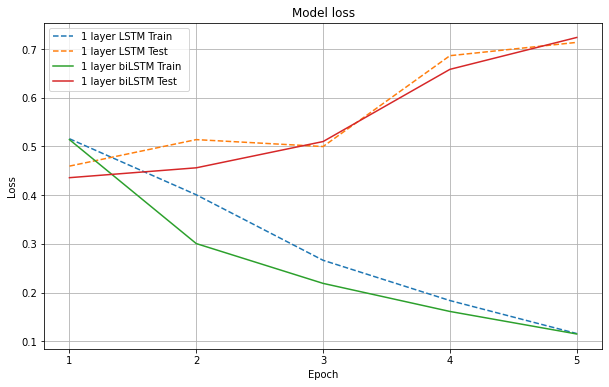

In [ ]:
# Plot training & validation loss values
import matplotlib.pyplot as plt

epoch_list = np.arange(1,6)

plt.figure(figsize=(10,6))
plt.grid()
plt.xticks(epoch_list)
# results for 1-layer lstm model
plt.plot(epoch_list, results_one_layer.history['loss'], "--", label="1 layer LSTM Train")
plt.plot(epoch_list, results_one_layer.history['val_loss'], "--", label = "1 layer LSTM Test")

# results for bi-lstm model
plt.plot(epoch_list, results_biLSTM.history['loss'], label="1 layer biLSTM Train ")
plt.plot(epoch_list, results_biLSTM.history['val_loss'], label = "1 layer biLSTM Test")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show();

## Challenge

You will be expected to use an Keras LSTM for a classicification task on the *Sprint Challenge*. 

--------
# 3. LSTM Text generation with Keras (Learn)

Using sequential models to generate text data is a very popular application of recursive deep learning models. A couple of popular applications are [**chat bots**](https://hackernoon.com/deep-learning-chatbot-everything-you-need-to-know-r11jm30bc) and language translators such as [**google translate**](https://ai.googleblog.com/2020/06/recent-advances-in-google-translate.html). 

In order to properly build a chat bot or translater you need to use multiple lstm models in an encoder & decoder framwork known as a [**sequence 2 sequence model**](https://keras.io/examples/nlp/lstm_seq2seq/) .


![](https://jeddy92.github.io/images/ts_intro/seq2seq_lang.png)

Also, now a days, using a standard LSTM isn't enough. You also have to use a version of lstm seq2seq models known as [**transformers**](https://towardsdatascience.com/transformers-141e32e69591). Transformers give seq2seq models the capacity to pay attention to specific portions of the input sequence, the most relevent portion in order to make a prediction. Yes, that's right, humanity has figured out how to convert attention into an algorithm. Next stop, self-awareness! 

The above mentions of sequence 2 sequence models and transformers are for a larger contextual understanding of the landscape of language models and how LSTMs fit into this landscape. Although **we will cover the encoder/decoder framework in a future lesson, transformers are outside the scope of Unit 4**. However, once you learn about LSTMs and encoder/decoder frameworks, you will have all necessary information to then go on and learn about transformers on your own. At that point, the only really new bit you'll be learning is the [**attention mechanism**](https://towardsdatascience.com/intuitive-understanding-of-attention-mechanism-in-deep-learning-6c9482aecf4f). 


As a first pass at text generation, we'll stick to standard LSTM models. 

-----
# Text Generation using LSTMs

What else can we do with LSTMs? Since we're analyzing the *sequence*, we can do more than classify - we can *generate* text. I'ved pulled some news stories using [newspaper](https://github.com/codelucas/newspaper/).

This example is drawn from the Keras [documentation](https://keras.io/examples/lstm_text_generation/).

In [ ]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence

import re
import numpy as np
import pandas as pd
import random
import sys
import os

# import a custom text data preparation class
!wget https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/main/module1-rnn-and-lstm/data_cleaning_toolkit_class.py
from data_cleaning_toolkit_class import data_cleaning_toolkit

--2021-09-14 01:33:45--  https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/main/module1-rnn-and-lstm/data_cleaning_toolkit_class.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6666 (6.5K) [text/plain]
Saving to: ‘data_cleaning_toolkit_class.py.1’

data_cleaning_toolk 100%[===================>]   6.51K  --.-KB/s    in 0s      

2021-09-14 01:33:45 (69.6 MB/s) - ‘data_cleaning_toolkit_class.py.1’ saved [6666/6666]



In [ ]:
# load text data (articles)
df = pd.read_json('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-3-Deep-Learning/main/module1-rnn-and-lstm/wp_articles.json')
df.head()

,article
0,Contributing columnist\n\nThe House is on fire...
1,When President Trump announced his decision to...
10,Russian President Vladimir Putin speaks at a s...
100,“The Queen’s Speech” is designed to acknowledg...
101,"Like an aging rock star, the president is now ..."


How many articles are in the database?

In [ ]:
len(df)

136

Clean the documents<br>
Chop them into text strings of length 20 characters<br>
Create X and y split

In [ ]:
###BEGIN SOLUTION 
# instantiate data cleaning toolkit
dctk = data_cleaning_toolkit()

# use regex to clean documents
df["clean_data"] = df.article.apply(lambda text: dctk.clean_data(text))

# move docs to array
#data = df['article'].values
data = df['clean_data'].values

# amount of chars in each doc vector 
doc_len = 20

# numerically encode documents
dctk.create_char_sequences(data, doc_len)

# create X and Y split
x, y = dctk.create_X_and_Y()
###END SOLUTION 

Created 168985 sequences.


Here is the first article

In [ ]:
(df['article'][0])

"Contributing columnist\n\nThe House is on fire. And with each passing day, Donald Trump defiles the office of the president. If only past defrocked presidents could provide a roadmap for this firestorm.\n\nAndrew Johnson fought impeachment vigorously and survived removal, but never won reelection. Richard Nixon got in the way of justice, but eventually bowed to the rule of law, accepting his asterisk in the annals of history and resigning before certain removal. Bill Clinton expressed contrition, went on to complete his presidency with high approval ratings and has remained a popular former president.\n\nIf you care about democracy, the rule of law and nearly 250 years of constitutional governance, take heed. President Trump is no Clinton or Nixon, or even Johnson. He will not go quietly. It will be ugly. He will betray us and the rule of law in the process — defying subpoenas, withholding documents, blocking witnesses.\n\nThis presidency is fouled with disrespect for rules, boundarie

Here is the cleaned version of the first article

In [ ]:
df['clean_data'][0]

'contributing columnistthe house is on fire and with each passing day donald trump defiles the office of the president if only past defrocked presidents could provide a roadmap for this firestormandrew johnson fought impeachment vigorously and survived removal but never won reelection richard nixon got in the way of justice but eventually bowed to the rule of law accepting his asterisk in the annals of history and resigning before certain removal bill clinton expressed contrition went on to complete his presidency with high approval ratings and has remained a popular former presidentif you care about democracy the rule of law and nearlyyears of constitutional governance take heed president trump is no clinton or nixon or even johnson he will not go quietly it will be ugly he will betray us and the rule of law in the processdefying subpoenas withholding documents blocking witnessesthis presidency is fouled with disrespect for rules boundaries and norms trump walked away from major agree

The `data` is an array containing the articles

In [ ]:
print(len(data))
data[0]

136


'contributing columnistthe house is on fire and with each passing day donald trump defiles the office of the president if only past defrocked presidents could provide a roadmap for this firestormandrew johnson fought impeachment vigorously and survived removal but never won reelection richard nixon got in the way of justice but eventually bowed to the rule of law accepting his asterisk in the annals of history and resigning before certain removal bill clinton expressed contrition went on to complete his presidency with high approval ratings and has remained a popular former presidentif you care about democracy the rule of law and nearlyyears of constitutional governance take heed president trump is no clinton or nixon or even johnson he will not go quietly it will be ugly he will betray us and the rule of law in the processdefying subpoenas withholding documents blocking witnessesthis presidency is fouled with disrespect for rules boundaries and norms trump walked away from major agree

We are chopping each of the 136 document into 20-character sequences


In [ ]:
type(x)

numpy.ndarray

In [ ]:
len(x)

168985

In [ ]:
len(x[0])

20

How is a single character in a sequence represented?<br>
-- say, the 10th character in the first sequence?

In [ ]:
print(len(x[0][10]))
x[0][10]
print(sum(x[0][10]))

27
1


Each character is represented as a one-hot encoded vector of length 121, with <br>
positions corresponding to the "vocabulary" of all the possible characters. <br>
There are 121 possible characters, including upper and lower case and punctuation.

In [ ]:
###BEGIN SOLUTION
# this is our encoded doc-term matrix 
dtm = dctk.sequences

# each doc is maxlen values long 
print(len(dctk.sequences[0]))

# want to know what this encoded document actually says?
# you'll need to the char-int look up dictionaries 
print(dctk.sequences[0])



20
[9, 19, 5, 18, 3, 0, 2, 17, 18, 0, 5, 11, 26, 9, 19, 1, 17, 12, 5, 0]


In [ ]:
# character to index dictionary
# keys are chars
# vlaues are ints
print(dctk.char_int)

# index to char dictionary
# keys are ints
# values are chars
print(dctk.int_char)

{'i': 0, 'l': 1, 'b': 2, 'r': 3, 'q': 4, 'n': 5, 'h': 6, 'e': 7, 'a': 8, 'c': 9, 'y': 10, 'g': 11, 'm': 12, 'd': 13, 'w': 14, 'f': 15, 's': 16, 'u': 17, 't': 18, 'o': 19, 'z': 20, 'x': 21, 'v': 22, 'k': 23, 'p': 24, 'j': 25, ' ': 26}
{0: 'i', 1: 'l', 2: 'b', 3: 'r', 4: 'q', 5: 'n', 6: 'h', 7: 'e', 8: 'a', 9: 'c', 10: 'y', 11: 'g', 12: 'm', 13: 'd', 14: 'w', 15: 'f', 16: 's', 17: 'u', 18: 't', 19: 'o', 20: 'z', 21: 'x', 22: 'v', 23: 'k', 24: 'p', 25: 'j', 26: ' '}


#### Check that the character encoding works properly
Use the integer-to-character dictionary to map the integer character encodings back to the characters they represent

In [ ]:
# now we can check to see that our encoding is correct 
for ind in dctk.sequences[0]:
    print (dctk.int_char[ind])
    
# number of features is the total number of unique chars in our corpos 
dctk.n_features

# (num_seqs, num features)
###END SOLUTION

c
o
n
t
r
i
b
u
t
i
n
g
 
c
o
l
u
m
n
i


27

Each successive string starts with the 5th character of the last

In [ ]:
for ind in dctk.sequences[1]:
    print (dctk.int_char[ind])
    

i
b
u
t
i
n
g
 
c
o
l
u
m
n
i
s
t
t
h
e


In [ ]:
# (num_seqs, seq length, num features)
x.shape

(168985, 20, 27)

The training labels are encodings of a single character.<br>
But what is this character?<br>
We are building a language model to predict the next character in a sequence, <br>
so each y corresponds to the next character after the 20th character of x!

In [ ]:
y.shape

(168985, 27)

In [ ]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False])

Let's check this:<br>
y[0] should correspond to the first character of x[1]

The code that generates `x` and `y` is in `data_cleaning_toolkit` method `create_X_and_Y()`.<br><br>
For the string in the $i\text{th}$ row of `x`, the character the language model is trying to predict should <br>
be the **first** character in the next row of `x`, <br>
i.e y[i] should be the first character in row  $i+1$ of `x`<br><br>
But it looks like something's wrong, because instead, the code assigns `y` to be the $16\text{th}$ character in the next row of `x`!<br>
This might be the reason the language model below doesn't train...
I haven't yet figured out how to fix `create_X_and_Y()` to make it do the right thing.<br><br>

Update: The code is **doing the right thing after all**. In the `data_cleaning_toolkit`, you find a `step` parameter which is set to $5$ and means that each sequence starts $5$ characters later than the previous one. So the $16\text{th}$ character in the $2\text{nd}$ row is the $21\text{st}$ character of the data set, which is the next character after the first row. <br><br>

**The take-away**: this is a perfect example of why it's important to take the time to *document* your code, so that the people who have to use it don't have to spend hours trying to figure out what it does!!

In [ ]:
print(np.argmax(y[0]))
print( [np.argmax(x[1,i,:]) for i in range(20) ])

16
[0, 2, 17, 18, 0, 5, 11, 26, 9, 19, 1, 17, 12, 5, 0, 16, 18, 18, 6, 7]


In [ ]:
print(np.argmax(y[1]))
print( [np.argmax(x[2,i,:]) for i in range(20) ])

26
[5, 11, 26, 9, 19, 1, 17, 12, 5, 0, 16, 18, 18, 6, 7, 26, 6, 19, 17, 16]


In [ ]:
print(np.argmax(y[2]))
print( [np.argmax(x[3,i,:]) for i in range(20) ])

7
[1, 17, 12, 5, 0, 16, 18, 18, 6, 7, 26, 6, 19, 17, 16, 7, 26, 0, 16, 26]


### Callback function to gauge progress at the end of each epoch

In [ ]:
def sample(preds, temperature=1.0):
    """
    Helper function to sample an index from a probability array
    """
    # convert preds to array 
    preds = np.asarray(preds).astype('float64')
    # scale values 
    preds = np.log(preds) / temperature
    # exponentiate values
    exp_preds = np.exp(preds)
    # this equation should look familar to you (hint: it's an activation function)
    preds = exp_preds / np.sum(exp_preds)
    # Draw samples from a multinomial distribution
    probas = np.random.multinomial(1, preds, 1)
    # return the index that corresponds to the max probability 
    return np.argmax(probas)

def on_epoch_end(epoch, _):
    """"
    Function invoked at end of each epoch. Prints the text generated by our model.
    """
    
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    

    start_index = random.randint(0, len(text) - dctk.maxlen - 1)
    
    generated = ''
    
    sentence = text[start_index: start_index + dctk.maxlen]
    generated += sentence
    
    print('----- Generating with seed: "' + sentence + '"')
    sys.stdout.write(generated)
    
    for i in range(40):
        
        x_dims = (1, dctk.maxlen, dctk.n_features)
        x_pred = np.zeros(x_dims)
        
        for t, char in enumerate(sentence):
            x_pred[0, t, dctk.char_int[char]] = 1
            
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds)
        next_char = dctk.int_char[next_index]
        
        sentence = sentence[1:] + next_char
        
        # explore the flush function and make sure that this is what we want 
        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

In [ ]:
# need this for on_epoch_end()
text = " ".join(data)

In [ ]:
# create callback object that will print out text generation at the end of each epoch 
# use for real-time monitoring of model performance
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
x[1].shape

(20, 27)

---------
### Build Text Generating Model

Set up the Adam optimizer to allow changing the learning rate

In [ ]:
# build a 1 layer LSTM language model 
from tensorflow.keras.optimizers import Adam
# specify learning rate and optimizer
opt = Adam(learning_rate=0.003)


In [ ]:
%%time
### BEGIN SOLUTION


# build another model for our task for forecasting what text should follow from our seed string 
model = Sequential()

# hidden layer 1 
model.add(LSTM(256, 
               input_shape=(dctk.maxlen, dctk.n_features), # think of input_shape as implicitly declaring the input layer 
               return_sequences=False)) # set to true whenever using 2 or more LSTM layers 

# hidden layer 2 
#model.add(LSTM(128))

# this is our output layer
# recall that n_features = num of nodes in output layer 
model.add(Dense(dctk.n_features, 
                activation='softmax'))

# notice that we are using categorical_crossentropy this time around - why?
model.compile(loss='categorical_crossentropy', 
              optimizer=opt)

# fit the model
# x and y are pretty large, consider sub-sampling
model.fit(x[:4000], y[:4000],
          batch_size=128,
          epochs=50,
          callbacks=[print_callback])
### END SOLUTION

Epoch 1/50
32/32 [==============================] - 2s 6ms/step - loss: 3.1001

----- Generating text after Epoch: 0
----- Generating with seed: "bs childrens series "
bs childrens series baojtmsedomah tsas a y ka  esllndem  cio
Epoch 2/50
32/32 [==============================] - 0s 6ms/step - loss: 2.7208

----- Generating text after Epoch: 1
----- Generating with seed: "rder you will have a"
rder you will have allcelcikestate tit  wrt in tt kroum g vi
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 2.5261

----- Generating text after Epoch: 2
----- Generating with seed: "eadily fall through "
eadily fall through rians fad  he nis anastlin  ons whewinsh
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 2.4175

----- Generating text after Epoch: 3
----- Generating with seed: "ump who told him the"
ump who told him the iousimsians be sigs enk kes  anareng io
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 2.3408

----

-------------
## Challenge

You will be expected to use a Keras LSTM to generate text on today's assignment. 

# Review

- <a href="#p1">Part 1: </a>Describe Neural Networks used for modeling sequences
    * Sequence Problems:
        - Time Series (like Stock Prices, Weather, etc.)
        - Text Classification
        - Text Generation
        - And many more! :D
    * LSTMs are generally preferred over RNNs for most problems
    * LSTMs are typically a single hidden layer of LSTM type; although, other architectures are possible.
    * Keras has LSTMs/RNN layer types implemented nicely
- <a href="#p2">Part 2: </a>Apply a LSTM to a text generation problem using Keras
    * Shape of input data is very important
    * Can take a while to train
    * You can use it to write movie scripts. :P 